In [1]:
import pickle
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk

In [2]:
cr_df = pd.read_pickle('../pickle_jar/CritRole_split.pkl')
cr_df['text'] = cr_df['text'].str.replace(r'♫', r'', regex=True).astype('str')
cr_df=cr_df.drop(321664) #another full produced song (not them singing at the table) skewing the sent length data badly
cr_df=cr_df.drop(78020)  #a badly coded line (spit out some meta info it looks like) skewing word len data
cr_df

,index,name,text,episode,timestamp,inaudible_speech,nonspeech
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,
1,1,LAURA,As in nnnn.,1,00:01:21,,
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises)
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,
...,...,...,...,...,...,...,...
434047,2722,MATT,"We're going to get through this together, guys.",99,03:47:47,,
434048,2723,SAM,Wash your stubbly face.,99,03:47:49,,
434049,2724,TRAVIS,Gross.,99,03:47:51,,
434050,2725,MATT,,99,03:47:52,,(cheering)


In [3]:
cr_df['name'] = cr_df['name'].str.replace(r'MTT', r'MATT', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'AMTT', r'MATT', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'NOTT', r'SAM', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'CALEB', r'LIAM', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'BEAU', r'MARISHA', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'JESTER', r'MATT', regex=True).astype('str')

## First thoughts and plans


### planning next data steps

Adding some new columns... Word token counts, word types & counts, sentence length (to calculate avg sentence length for speakers). Ultimately will remove the 'text' column as to not share data I can't share. 

### dividing the data

What subgroups are we planning to compare here? DM and players, men and women. I'm going to create new DF slices for these groups. Players, men (with DM), men (without DM), and women. I won't create a DM only DF since I can just select for "Matt" from the base df and get the same information. I want to do this AFTER the new columns are added so all data is included.

### other points of measurement

hedging (look into how past projects measured this), interruptions, jargon

### planning visualizations

## Getting started

First thing's first, let's just see how many lines each speaker has as a basis to go off of for the rest of our research.

The problem I had initially was counting *all* lines associated per name, including lines in the 'text' column that are empty because the value had been moved to the 'nonspeech' or 'inaudible' columns instead. To combat this, I've selected only the name and text columns and dropped any row from the text column that contains no text. By doing this we've eliminated 11,474 lines from the text volume that have no value.

In [4]:
lcount = cr_df[['name', 'text']].copy()
lcount = lcount[lcount['text'] != '']
lcount

,name,text
0,MATT,We've got some cool stuff to talk about. First...
1,LAURA,As in nnnn.
2,MATT,"Nnnn. But yeah, so they're going to be a long-..."
3,TRAVIS,Would you like some?
4,MATT,"So yeah. I'm super excited to have that, guys...."
...,...,...
434045,MATT,"Do your research, wash your hands, all this st..."
434046,ASHLEY,Wash your hands immediately.
434047,MATT,"We're going to get through this together, guys."
434048,SAM,Wash your stubbly face.


In [5]:
spcount = pd.DataFrame(lcount.groupby(['name'])['text'].count())
spcount = spcount.reset_index()
spcount = spcount.sort_values('text', ascending=False)
spcount.head(n=8)

,name,text
200,MATT,109579
104,LAURA,58407
245,SAM,50447
168,MARISHA,48138
316,TRAVIS,48073
136,LIAM,40254
293,TALIESIN,39736
14,ASHLEY,17166


So here are the line counts per main cast member! Very interesting stuff. Predictably, Matt talks a *lot* more than every other participant, almost twice as much as the second most lines spoken.

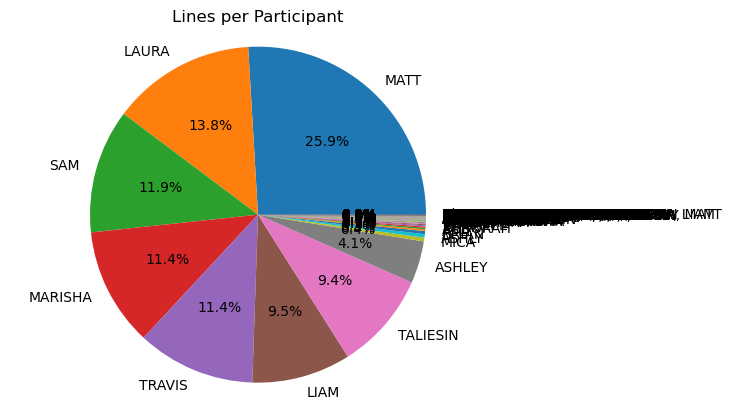

In [6]:
plt.pie(spcount['text'], labels=spcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Lines per Participant')
plt.show()

## Exploring Results

First of all, there is some important information to add some context to the information we're looking at. 

#### 1
First thing is attendance. The fan-run website [CritRole Stats](https://www.critrolestats.com/stats) tracks a number of statistics for each episode of Critical Role. The one we're looking at is Campaign 2 (Mighty Nein Campaign). They have very helpfully included attendance among their stats!<br>
Not every player was present for every single episode. Laura and Travis left for some time for parental leave, Taliesin had a character death, and Ashley was away for a time filming for a television show. This show spanned multiple years, Jan 2018 to June 2021, on a weekly basis except for a period from March to July 2020 for quarantine. It's not odd to have someone have to miss an episode sometimes.

Here is the attendance list by CR Stats:<br>
Matt      -> 141<br>
Marisha	  -> 141<br>
Sam	      -> 141<br>
Liam	  -> 140<br>
Taliesin  -> 139<br>
Travis	  -> 136<br>
Laura	  -> 133<br>
Ashley	  -> 86

Interestingly, this explains why Ashley has as few lines as she does, but otherwise there is not a 1:1 match of attendance to how much a player spoke.

#### 2
Another thing to consider is characters. Laura may have been in the second to least episodes out of the full cast, but her character, Jester, is an excitable motormouth. Marisha and Travis, on the other hand, play slightly more serious characters , and Liam, Ashley, and Taliesin (from episode 30-ish onward) play more stoic types. 

#### 3
Finally, roles. At the top of each episode (or most of them, at least), two things happen. Sam reads ads for the show, often making them into skits or scripts full of jokes and siliness. Then, often, Laura updates viewers on new merch added to their store, what's available, what's coming and when it'll be available, and so on. It wouldn't be surprising to find that this affects their speech totals by a good bit.

Since I spent so long crafting that nonspeech column let's take a look at its values just to see what we see. 

In [7]:
allsounds = cr_df['nonspeech'].value_counts()
allsounds[:15]

                408173
(laughter)        6163
(laughs)          1933
(laughs)           874
(laughter)         720
(whispering)       416
(cheering)         338
(gasps)            293
(gasps)            281
(singing)          278
(sighs)            273
(groaning)         254
(counting)         242
(sighs)            195
(groans)           174
Name: nonspeech, dtype: int64

In [8]:
scount = cr_df[['name', 'nonspeech']].copy()
scount = scount[scount['nonspeech'] != '']
nscount = pd.DataFrame(scount.groupby(['name'])['nonspeech'].count())
nscount = nscount.reset_index()
nscount = nscount.sort_values('nonspeech', ascending=False)
nscount.head(n=8)

,name,nonspeech
92,MATT,7176
142,TRAVIS,3801
49,LAURA,3311
115,SAM,3265
77,MARISHA,2451
61,LIAM,2393
134,TALIESIN,1341
10,ASHLEY,1005


Not extremely important since it's not part of speech analysis but I put the work in and I wanted to see it.
Not surprising again! Matt being the first makes sense, he is known as a DM for including sound effects (and being very good at them). Just a cool stat... moving on!

## Adding new columns

Tokenizing (should we tokenize including punctuation in this case...?), token counts & averages, word types (which will be shared) (checkw ith na rae.... word types are deemed ok for the FULL text or line by line?), sentence count, sentence length.

### Word counts (per line)

In [9]:
tokens = cr_df.text.map(nltk.word_tokenize)
tokens

0         [We, 've, got, some, cool, stuff, to, talk, ab...
1                                         [As, in, nnnn, .]
2         [Nnnn, ., But, yeah, ,, so, they, 're, going, ...
3                               [Would, you, like, some, ?]
4         [So, yeah, ., I, 'm, super, excited, to, have,...
                                ...                        
434047    [We, 're, going, to, get, through, this, toget...
434048                       [Wash, your, stubbly, face, .]
434049                                           [Gross, .]
434050                                                   []
434051                                                   []
Name: text, Length: 434050, dtype: object

In [10]:
cr_df['tokens']=tokens         #create token column
cr_df['word_count'] = cr_df.tokens.map(len)   #count total tokens per line

cr_df.head()

,index,name,text,episode,timestamp,inaudible_speech,nonspeech,tokens,word_count
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,"[We, 've, got, some, cool, stuff, to, talk, ab...",179
1,1,LAURA,As in nnnn.,1,00:01:21,,,"[As, in, nnnn, .]",4
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,"[Nnnn, ., But, yeah, ,, so, they, 're, going, ...",139
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),"[Would, you, like, some, ?]",5
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,"[So, yeah, ., I, 'm, super, excited, to, have,...",144


So we know who has the most speech events (Matt) but what about who says the most words? Someone with fewer speech events (lines) could have one very very long speech, who knows

### Total words per speaker

In [11]:
wcount = pd.DataFrame(cr_df.groupby('name').word_count.sum())
wcount = wcount.reset_index()
wcount = wcount.sort_values('word_count', ascending=False)
wcount.head(n=8)

,name,word_count
211,MATT,1645574
112,LAURA,523524
260,SAM,438023
337,TRAVIS,417547
176,MARISHA,414750
144,LIAM,411400
312,TALIESIN,372572
16,ASHLEY,129271


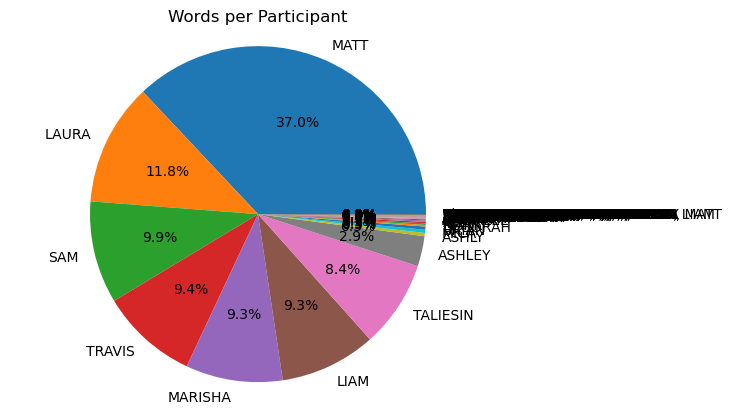

In [12]:
plt.pie(wcount['word_count'], labels=wcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Words per Participant')
plt.show()

bla lbhalbnhalb only travis and marisha trade places means he says just a little more
not only is Matt talking more, he's *saying* more.

### Unique words per speaker

In [13]:
cr_df['types'] = cr_df['tokens'].apply(lambda tokens: [w.lower() for w in tokens])

In [14]:
cr_df['types'] = cr_df['types'].apply(set)

In [15]:
cr_df['type_count'] = cr_df.types.map(len) 
cr_df.head()

,index,name,text,episode,timestamp,inaudible_speech,nonspeech,tokens,word_count,types,type_count
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,"[We, 've, got, some, cool, stuff, to, talk, ab...",179,"{cool, going, foremost, talking, is, been, has...",95
1,1,LAURA,As in nnnn.,1,00:01:21,,,"[As, in, nnnn, .]",4,"{in, ., as, nnnn}",4
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,"[Nnnn, ., But, yeah, ,, so, they, 're, going, ...",139,"{going, $, 'm, created, which, book, years, bu...",85
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),"[Would, you, like, some, ?]",5,"{?, you, would, like, some}",5
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,"[So, yeah, ., I, 'm, super, excited, to, have,...",144,"{cool, away, 'm, confused, checkout, also, sec...",81


In [16]:
typecount = pd.DataFrame(cr_df.groupby('name').type_count.sum())
typecount = typecount.reset_index()
typecount = typecount.sort_values('type_count', ascending=False)
typecount.head(n=8)

,name,type_count
211,MATT,1368680
112,LAURA,469806
260,SAM,394293
337,TRAVIS,379129
176,MARISHA,372087
144,LIAM,366454
312,TALIESIN,335381
16,ASHLEY,117499


In [17]:
countsdf = wcount.merge(typecount, how='left', on='name', suffixes=('', '_y'))
countsdf.drop(countsdf.filter(regex='_y$').columns, axis=1, inplace=True)

In [18]:
countsdf = countsdf[countsdf['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]

In [19]:
countsdf

,name,word_count,type_count
0,MATT,1645574,1368680
1,LAURA,523524,469806
2,SAM,438023,394293
3,TRAVIS,417547,379129
4,MARISHA,414750,372087
5,LIAM,411400,366454
6,TALIESIN,372572,335381
7,ASHLEY,129271,117499


<Axes: xlabel='name'>

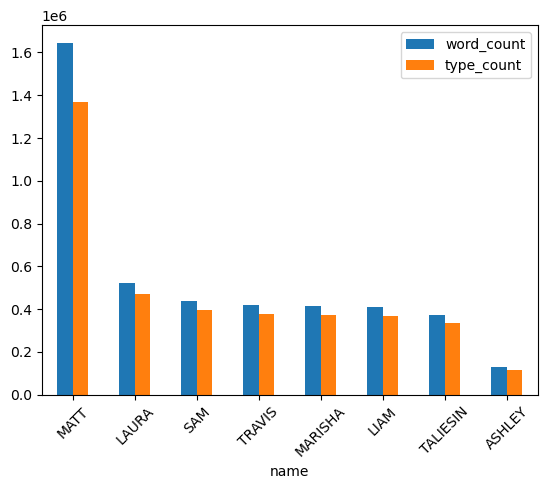

In [21]:
countsdf.set_index(['name']).plot.bar(rot=45)

## Word Length

In [ ]:
wlength = cr_df.apply(lambda row: [len(w) for w in (row['tokens'])], axis=1)
cr_df = cr_df.drop('tokens', axis=1)     #drop that toks col, we don't actually want it

In [ ]:
cr_df['avg_word_length'] = wlength.map(sum)/cr_df['word_count']
cr_df.head()

In [ ]:
cr_df['avg_word_length'].describe()

In [ ]:
cr_df[cr_df['avg_word_length']==16]

Interesting! I guess NLTK thinks of a hyphen as part of a compound words and counts it only as one long word? 

### Sentences and sentence length

In [ ]:
sents = cr_df.text.map(nltk.sent_tokenize)
sents[0]   #we can take a look at that full opening speech

In [ ]:
sentlength = sents.map(len)    #number of sentences spoken per line
sentlength

In [ ]:
avgsentlength = cr_df.word_count/sentlength    #avg length of sentence per line or speech event
avgsentlength

In [ ]:
cr_df['avg_sent_length']=avgsentlength
cr_df.head()

### Let's investigate

Take a look at some of these sentences

In [ ]:
cr_df['avg_sent_length'].describe()

In [ ]:
#LOTS of single word sentences, not surprising!
cr_df[cr_df['avg_sent_length']==1]

In [ ]:
#but what about that one long sentence?
cr_df[cr_df['avg_sent_length']==126]

In [ ]:
cr_df.text[354187]

This makes sense to me! Looking into it a bit further it looks like Sam was wanting to make some alterations to his character (Nott)'s crossbow which required a skill check. He rolled a 16 (not bad) and Matt narrated the results of his efforts.

Not surprising that the narrator would narrate at length sometimes!

### Average sentence length per speaker

In [ ]:
slen = pd.DataFrame(cr_df.groupby('name').avg_sent_length.mean())
slen = slen.reset_index()
slen = slen.sort_values('avg_sent_length', ascending=False)
slen.head(n=8)

In [ ]:
avgsents = slen[slen['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]
avgsents

In [ ]:
plt.pie(avgsents['avg_sent_length'], labels=avgsents['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Average Sentence Length per Participant')
plt.show()

reasonable to do something like avg sentence length of 5+ (to drop instances of single word sentences like "yeah" or "okay") - look into who typically has longer sentences overall. 

also write up an analysis on this too

In [ ]:
travis['text'].str.count(r'Eldritch Blast').sum()

In [ ]:
liam['text'].str.count(r'Ja').sum()

In [ ]:
ep2 = cr_df[cr_df['episode']=='2']
ep2[-130:-120]

a link to the moment of chaos, just for comparison - this is a good reference point for chaos and overlapping speech

https://youtu.be/MPELLuQXVcE?si=13too39HcHj5Cfow&t=14475

In [ ]:
ashley = cr_df[cr_df['name']=='ASHLEY']
matt = cr_df[cr_df['name']=='MATT']
marisha = cr_df[cr_df['name']=='MARISHA']
taliesin = cr_df[cr_df['name']=='TALIESIN']
sam = cr_df[cr_df['name']=='SAM']
liam = cr_df[cr_df['name']=='LIAM']
laura = cr_df[cr_df['name']=='LAURA']
travis = cr_df[cr_df['name']=='TRAVIS']

In [ ]:
women = [ashley, marisha, laura]
women_df = pd.concat(women)
women_df

In [ ]:
men = [matt, taliesin, sam, liam, travis]
men_df = pd.concat(men)
men_df

In [ ]:
nondm_men = [taliesin, sam, liam, travis]
nondm_men_df = pd.concat(nondm_men)
nondm_men_df

In [ ]:
players = [ashley, marisha, taliesin, sam, liam, laura, travis]
players_df = pd.concat(players)
players_df

In [ ]:
matt